**🚀 Predicting the variance-covariance matrix for next quarter**

- 🔍 *Use CNN model* to predict next quarter's **covariances**.
- 📉 *Currently uses daily returns to generate enough sample data* with a 63 day rolling window for **sufficient samples**.
- 🧠 *Trains* **Model** from **2018-07-01** to **2021-12-31** using the **CNN**


**Imports and Generate Matrices**

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:

# SPDR Sector ETFs
tickers = ["XLF", "XLK", "XLE", "XLY", "XLP", "XLV", "XLI", "XLU", "XLRE", "XLB", "XLC"]

# Dates
start_train, end_train = "2018-07-01", "2021-12-31"
start_test, end_test = "2022-01-01", "2024-12-31"

# Download and clean data
def get_cleaned_prices(tickers, start, end, threshold=0.05):
    data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)['Adj Close']
    data = data.ffill().bfill().dropna()
    valid_cols = data.isna().mean() < threshold
    return data.loc[:, valid_cols]

# Generate daily rolling 63-day covariance matrices
def generate_cov_matrices(prices, window=63):
    log_returns = np.log(prices / prices.shift(1)).dropna()
    cov_matrices = []
    dates = []

    for i in range(window, len(log_returns)):
        window_returns = log_returns.iloc[i - window:i]
        cov_matrix = window_returns.cov().values
        cov_matrices.append(cov_matrix)
        dates.append(log_returns.index[i])

    return np.array(cov_matrices), dates

# Fetch prices
prices_train = get_cleaned_prices(tickers, start_train, end_train)
prices_test = get_cleaned_prices(tickers, start_test, end_test)

# Keep only common tickers
common_tickers = sorted(set(prices_train.columns) & set(prices_test.columns))
prices_train = prices_train[common_tickers]
prices_test = prices_test[common_tickers]

# Generate daily rolling cov matrices
cov_train, train_dates = generate_cov_matrices(prices_train)
cov_test, test_dates = generate_cov_matrices(prices_test)

# Predict 1 quarter ahead (63 trading days)
prediction_horizon = 63

X_train = cov_train[:-prediction_horizon]
y_train = cov_train[prediction_horizon:]

X_test = cov_test[:-prediction_horizon]
y_test = cov_test[prediction_horizon:]

# Shapes
print("Final tickers used:", common_tickers)
print("Train cov matrices shape:", cov_train.shape)
print("Test cov matrices shape:", cov_test.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Final tickers used: ['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']
Train cov matrices shape: (818, 11, 11)
Test cov matrices shape: (688, 11, 11)
X_train shape: (755, 11, 11)
y_train shape: (755, 11, 11)
X_test shape: (625, 11, 11)
y_test shape: (625, 11, 11)


**Visualize Random Matrix**

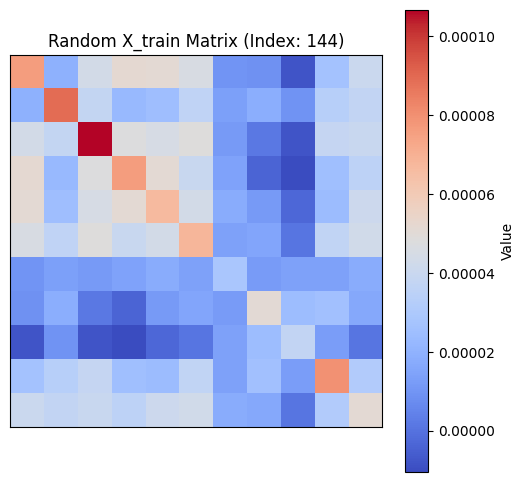

In [3]:

# Select a random index from X_train
random_index = random.randint(0, X_train.shape[0] - 1)
random_matrix = X_train[random_index]

# Plot the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(random_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Value')
plt.title(f'Random X_train Matrix (Index: {random_index})')
plt.xticks([])
plt.yticks([])
plt.show()

**Normalize Matrices**

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Normalization
X_train_norm = X_train / np.max(X_train, axis=(1, 2), keepdims=True)
y_train_norm = y_train / np.max(y_train, axis=(1, 2), keepdims=True)
X_test_norm = X_test / np.max(X_test, axis=(1, 2), keepdims=True)
y_test_norm = y_test / np.max(y_test, axis=(1, 2), keepdims=True)

# Sequence length (time steps)
sequence_length = 5

# Sequence generation
X_train_seq = np.array([
    X_train_norm[i - sequence_length:i]
    for i in range(sequence_length, len(X_train_norm))
])
y_train_seq = y_train_norm[sequence_length:]

X_test_seq = np.array([
    X_test_norm[i - sequence_length:i]
    for i in range(sequence_length, len(X_test_norm))
])
y_test_seq = y_test_norm[sequence_length:]

# Add channel dimension for CNN: (samples, time, 11, 11, 1)
X_train_seq = X_train_seq[..., np.newaxis]
X_test_seq = X_test_seq[..., np.newaxis]
y_train_seq = y_train_seq[..., np.newaxis]
y_test_seq = y_test_seq[..., np.newaxis]

print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)


X_train_seq shape: (750, 5, 11, 11, 1)
y_train_seq shape: (750, 11, 11, 1)


**Initial Model**

In [5]:
def euclidean_distance_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=[1, 2, 3])))

def build_cnn_lstm_model(seq_len, input_shape, filters1=32, filters2=64):
    input_layer = layers.Input(shape=(seq_len, *input_shape))  # (time, 11, 11, 1)

    x = layers.TimeDistributed(layers.Conv2D(filters1, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.Conv2D(filters2, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)  # (batch, time, features)

    x = layers.LSTM(128, return_sequences=False)(x)

    x = layers.Dense(11 * 11)(x)
    output = layers.Reshape((11, 11, 1))(x)

    return models.Model(inputs=input_layer, outputs=output)

# Build and compile the model
input_shape = (11, 11, 1)
model = build_cnn_lstm_model(sequence_length, input_shape)
model.compile(optimizer='adam', loss=euclidean_distance_loss)
model.summary()

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

# Evaluate
train_loss = model.evaluate(X_train_seq, y_train_seq, verbose=0)
print(f"Training Euclidean Loss: {train_loss:.6f}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 11, 11, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 11, 11, 32)  │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 11, 11, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 64)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 121)            │        15,609 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 11, 11, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,241 (520.47 KB)

 Trainable params: 133,241 (520.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.6551 - val_loss: 0.7941
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3115 - val_loss: 0.8975
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2433 - val_loss: 0.7752
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1847 - val_loss: 0.7340
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0487 - val_loss: 0.6329
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0827 - val_loss: 0.7426
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0918 - val_loss: 0.6413
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0094 - val_loss: 0.6848
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0515 - val_loss: 0.6833
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9786 - val_loss: 0.6847
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9347 - val_loss: 0.7352
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8

**Predict on Train Data**

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


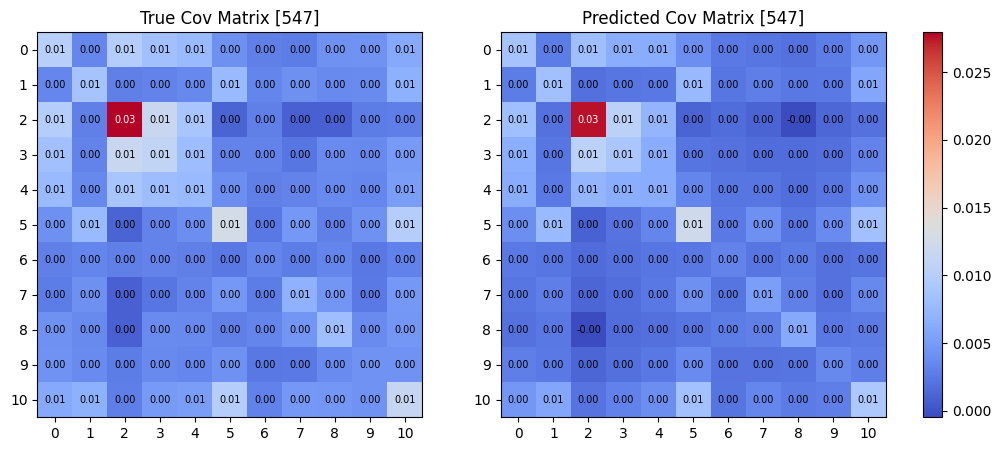

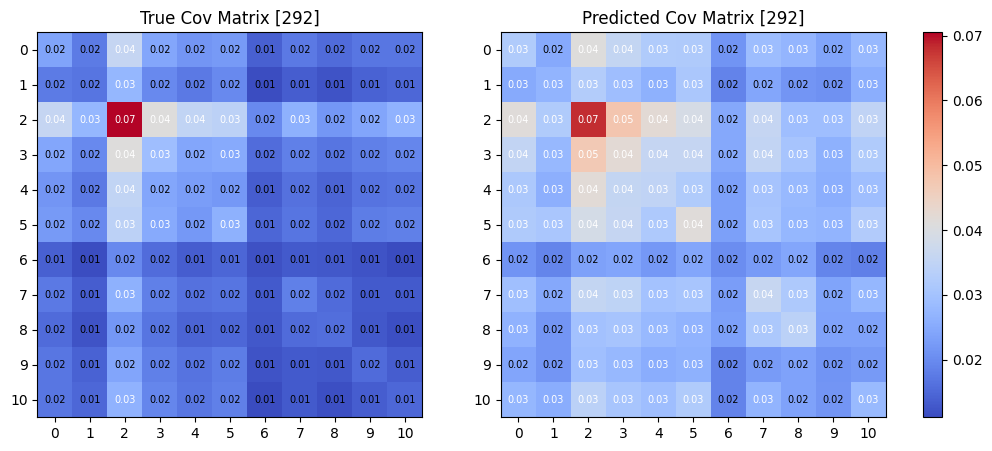

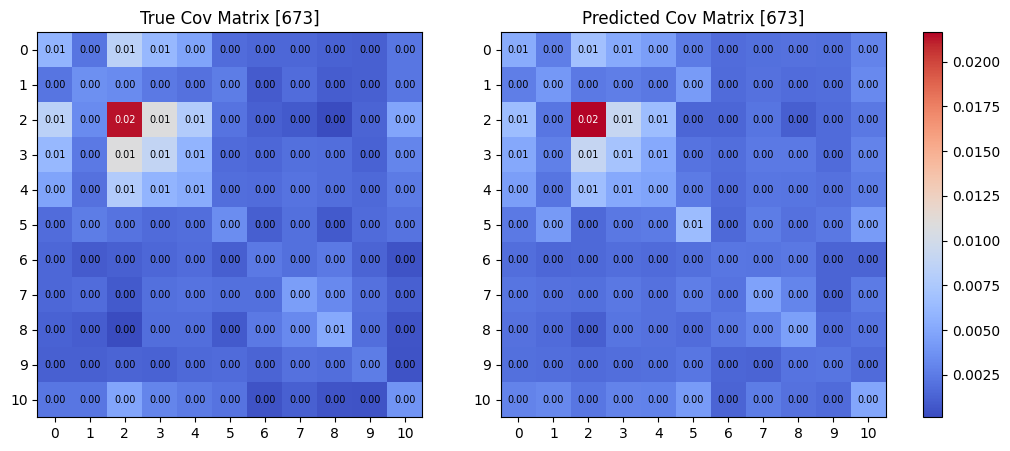

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------
# Predict on training data (sequence-based model)
# ----------------------------------------
y_train_pred_seq = model.predict(X_train_seq)

# Remove single channel for ease of operations
y_train_pred_flat = y_train_pred_seq.squeeze()  # (750, 11, 11)
y_train_true_flat = y_train_seq.squeeze()       # (750, 11, 11)

# ----------------------------------------
# Denormalize the predictions and targets
# ----------------------------------------

# Recalculate max values for correct broadcasting (750, 1, 1)
y_train_max = np.max(y_train[sequence_length:], axis=(1, 2), keepdims=True)

# Denormalize
y_train_pred_denorm = y_train_pred_flat * y_train_max
y_train_true_denorm = y_train_true_flat * y_train_max

# Scale to Quarterly covariance (63 trading days)
y_train_pred_scaled = y_train_pred_denorm * 63
y_train_true_scaled = y_train_true_denorm * 63

# ----------------------------------------
# Heatmap visualization function (same)
# ----------------------------------------

def plot_train_heatmaps(true_matrix, pred_matrix, idx):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    cmap = 'coolwarm'

    vmin = min(true_matrix.min(), pred_matrix.min())
    vmax = max(true_matrix.max(), pred_matrix.max())

    matrices = [true_matrix, pred_matrix]
    titles = [f'True Cov Matrix [{idx}]', f'Predicted Cov Matrix [{idx}]']

    for ax, mat, title in zip(axs, matrices, titles):
        im = ax.imshow(mat, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xticks(range(mat.shape[1]))
        ax.set_yticks(range(mat.shape[0]))

        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                value = round(mat[i, j], 2)
                color = 'white' if abs(value) > (vmax - vmin) / 2 else 'black'
                ax.text(j, i, f"{value:.2f}", ha='center', va='center', color=color, fontsize=7)

    fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)
    plt.show()

# ----------------------------------------
# Example: visualize 3 random training predictions
# ----------------------------------------

train_sample_indices = random.sample(range(len(y_train_true_scaled)), 3)
for idx in train_sample_indices:
    plot_train_heatmaps(y_train_true_scaled[idx], y_train_pred_scaled[idx], idx)



**Param Grid**

**Grid Search**

In [8]:
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import ParameterGrid
import tensorflow.keras.backend as K

# Define custom loss function
def euclidean_distance_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=[1, 2, 3])))

# Define model
def build_cnn_lstm_model(seq_len, input_shape, filters1=32, filters2=64, lstm_units=128):
    input_layer = layers.Input(shape=(seq_len, *input_shape))  # (time, 11, 11, 1)

    x = layers.TimeDistributed(layers.Conv2D(filters1, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.Conv2D(filters2, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)  # (batch, time, features)

    x = layers.LSTM(lstm_units, return_sequences=False)(x)
    x = layers.Dense(11 * 11)(x)
    output = layers.Reshape((11, 11, 1))(x)

    return models.Model(inputs=input_layer, outputs=output)

# Grid parameters
param_grid = {
    'filters1': [16, 32],
    'filters2': [32, 64],
    'lstm_units': [64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [16, 32]
}

input_shape = (11, 11, 1)
seq_len = X_train_seq.shape[1]  # usually 5
X = X_train_seq
y = y_train_seq

results = []
grid = list(ParameterGrid(param_grid))

for i, params in enumerate(grid):
    print(f"\nRunning config {i + 1}/{len(grid)}: {params}")

    # Build model
    model = build_cnn_lstm_model(
        seq_len,
        input_shape,
        filters1=params['filters1'],
        filters2=params['filters2'],
        lstm_units=params['lstm_units']
    )

    # Set optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'])
    else:
        optimizer = RMSprop(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss=euclidean_distance_loss)

    # Train model
    history = model.fit(
        X, y,
        epochs=10,
        batch_size=params['batch_size'],
        validation_split=0.1,
        verbose=0
    )

    # Evaluate model
    loss = model.evaluate(X, y, verbose=0)
    print(f"Train Loss: {loss:.6f}")

    results.append({
        'params': params,
        'train_loss': loss
    })

    # Clear memory
    K.clear_session()



Running config 1/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'learning_rate': 0.001, 'lstm_units': 64, 'optimizer': 'adam'}
Train Loss: 0.979872


Running config 2/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'learning_rate': 0.001, 'lstm_units': 64, 'optimizer': 'rmsprop'}
Train Loss: 1.280326

Running config 3/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'learning_rate': 0.001, 'lstm_units': 128, 'optimizer': 'adam'}
Train Loss: 0.942533

Running config 4/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'learning_rate': 0.001, 'lstm_units': 128, 'optimizer': 'rmsprop'}
Train Loss: 1.070706

Running config 5/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'learning_rate': 0.0005, 'lstm_units': 64, 'optimizer': 'adam'}
Train Loss: 1.026926

Running config 6/64: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'learning_rate': 0.0005, 'lstm_units': 64, 'optimizer': 'rmsprop'}
Train Loss: 1.138612

Running config 7/64: {'batch_size': 16, 'fi

**Results**

In [9]:
sorted_results = sorted(results, key=lambda x: x['train_loss'])
for rank, result in enumerate(sorted_results[:5], 1):
    print(f"#{rank} Loss: {result['train_loss']:.6f} | Params: {result['params']}")

#1 Loss: 0.889883 | Params: {'batch_size': 16, 'filters1': 32, 'filters2': 64, 'learning_rate': 0.001, 'lstm_units': 64, 'optimizer': 'adam'}
#2 Loss: 0.926685 | Params: {'batch_size': 16, 'filters1': 32, 'filters2': 64, 'learning_rate': 0.001, 'lstm_units': 128, 'optimizer': 'adam'}
#3 Loss: 0.942414 | Params: {'batch_size': 16, 'filters1': 16, 'filters2': 64, 'learning_rate': 0.001, 'lstm_units': 128, 'optimizer': 'adam'}
#4 Loss: 0.942533 | Params: {'batch_size': 16, 'filters1': 16, 'filters2': 32, 'learning_rate': 0.001, 'lstm_units': 128, 'optimizer': 'adam'}
#5 Loss: 0.958438 | Params: {'batch_size': 16, 'filters1': 32, 'filters2': 32, 'learning_rate': 0.001, 'lstm_units': 64, 'optimizer': 'adam'}


**Train best model with 30 epochs**

In [13]:
# Best parameters from grid search (example values)
best_params = {
    'filters1': 32,
    'filters2': 64,
    'kernel_size': (5, 5),
    'learning_rate': 0.001,
    'batch_size': 16,
    'optimizer': 'adam',
    'lstm_units': 128  # Include the LSTM units based on grid search
}

# Build the CNN-LSTM model with the best parameters
best_model = build_cnn_lstm_model(seq_len=sequence_length, input_shape=input_shape, 
                              filters1=best_params['filters1'], filters2=best_params['filters2'], 
                              lstm_units=best_params['lstm_units'])

# Compile the model with the selected optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']) if best_params['optimizer'] == 'adam' else tf.keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])
best_model.compile(optimizer=optimizer, loss=euclidean_distance_loss)

# Retrain the model on the full training data with the best batch size
history = best_model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=best_params['batch_size'], verbose=1)

# Optionally, evaluate the model after training
train_loss = best_model.evaluate(X_train_seq, y_train_seq, verbose=0)
print(f"Training Euclidean Loss: {train_loss:.6f}")


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.4038
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3664
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1387
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0475
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0228
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9766
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0259
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9331
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8579
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8545
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8400
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8369
Epoch 13/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7886
Epoch 14/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8027
Epoch 15/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7599
Epoc

Testing Euclidean Loss: 2.003940
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


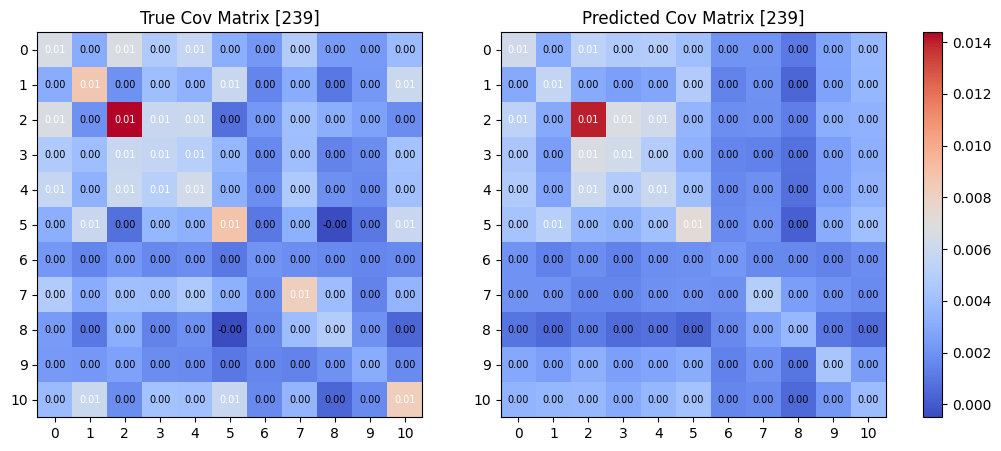

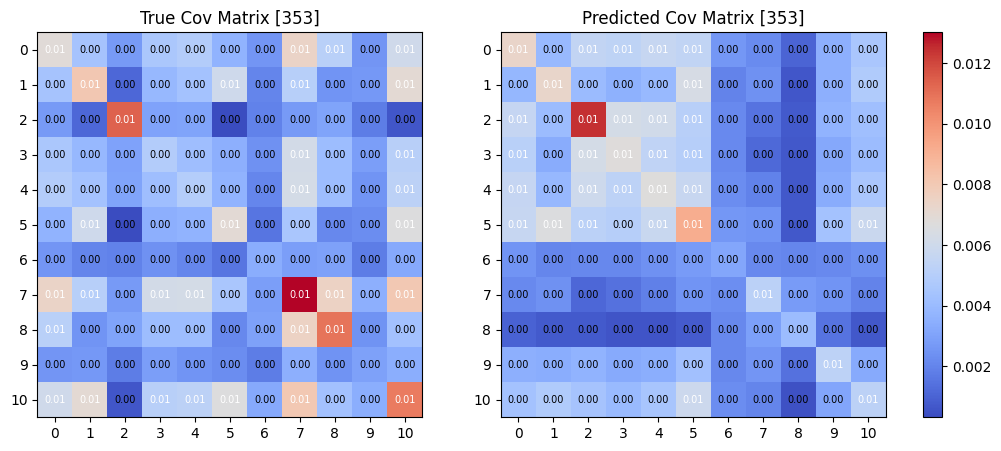

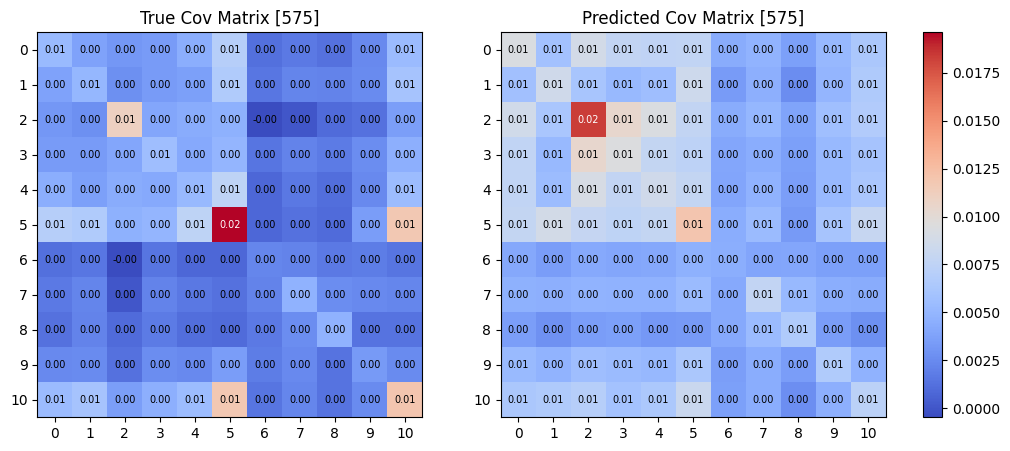

In [14]:
# Evaluate the model on testing data
test_loss = best_model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Testing Euclidean Loss: {test_loss:.6f}")

# Predict on testing data
y_test_pred_seq = best_model.predict(X_test_seq)

# Denormalize predictions and true values
y_test_max = np.max(y_test[sequence_length:], axis=(1, 2), keepdims=True)
y_test_pred_denorm = y_test_pred_seq.squeeze() * y_test_max
y_test_true_denorm = y_test_seq.squeeze() * y_test_max

# Scale to Quarterly covariance (63 trading days)
y_test_pred_scaled = y_test_pred_denorm * 63
y_test_true_scaled = y_test_true_denorm * 63

# Visualize a few predictions
test_sample_indices = random.sample(range(len(y_test_true_scaled)), 3)
for idx in test_sample_indices:
    plot_train_heatmaps(y_test_true_scaled[idx], y_test_pred_scaled[idx], idx)

In [1]:
from models import save_model

# Save the best model
save_model(best_model, model_name='cnn_lstm_best')

NameError: name 'best_model' is not defined